# Implementación - CASO 2

Se reutilizará parte de la implementación del caso base

Capacidad homogénea Q - Caso Base: 104
Instancia CVRP Caso Base creada. Nodos: 24  | Fuel price: 16300.0  | Fuel eff: 30.0

=== GA - Caso Base ===
Mejor costo encontrado: 723284.0622742594
Número de vehículos (rutas): 4
  Ruta: [0, 20, 23, 3, 17, 11, 8, 0]
  Ruta: [0, 6, 4, 15, 22, 13, 14, 0]
  Ruta: [0, 5, 9, 24, 16, 10, 1, 18, 0]
  Ruta: [0, 12, 21, 7, 19, 2, 0]


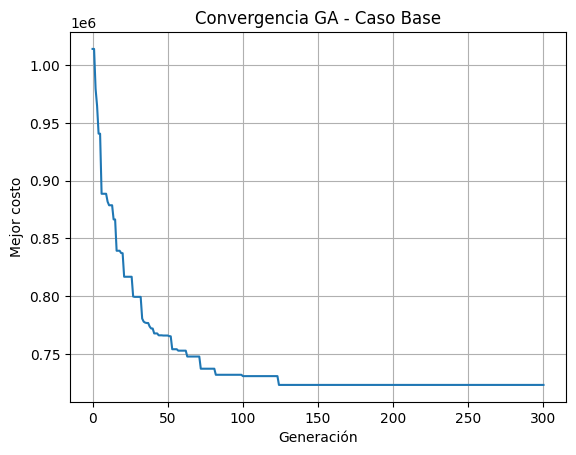


CSV de verificación Caso Base generado: verificacion_metaheuristica_GA_caso_base.csv
Suma de costos por ruta: 723284.0599999999
Mejor costo del GA (Caso Base): 723284.0622742594

Capacidad homogénea Q - Caso 2: 68
Instancia CVRP Caso 2 creada. Nodos: 9

=== GA - Caso 2 ===
Mejor costo encontrado: 335313.33571792726
Número de vehículos (rutas): 2
  Ruta: [0, 9, 2, 1, 4, 6, 0]
  Ruta: [0, 3, 8, 7, 5, 0]


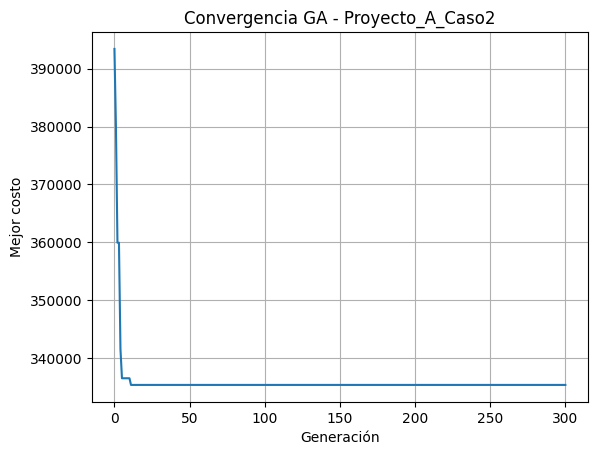


CSV de verificación Caso 2 generado: verificacion_metaheuristica_GA_A_caso2.csv
Suma de costos por ruta (Caso 2): 335313.32999999996
Mejor costo del GA (Caso 2): 335313.33571792726


In [7]:
# ============================================================
# 0. IMPORTS
# ============================================================

import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# ============================================================
# 1. FUNCIONES GENERALES (Haversine, Clase CVRP, GA)
# ============================================================

def haversine_km(lat1, lon1, lat2, lon2):
    """
    Distancia Haversine en km entre dos puntos (lat, lon) en grados.
    """
    R = 6371.0
    phi1 = math.radians(lat1)
    phi2 = math.radians(lat2)
    dphi = math.radians(lat2 - lat1)
    dlambda = math.radians(lon2 - lon1)

    a = (math.sin(dphi / 2.0) ** 2
         + math.cos(phi1) * math.cos(phi2) * math.sin(dlambda / 2.0) ** 2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    return R * c


class CVRPInstance:
    def __init__(self, distance_matrix, demands, Q,
                 C_fixed, C_dist, C_time,
                 fuel_price, fuel_efficiency,
                 speed=1.0):
        """
        distance_matrix: matriz NxN de distancias entre nodos 0..n
        demands: dict {nodo -> demanda}, 0 = depósito con demanda 0
        Q: capacidad homogénea del vehículo
        C_fixed, C_dist, C_time: parámetros de costo
        fuel_price: COP por galón
        fuel_efficiency: km por galón
        speed: km/h
        """
        self.distance_matrix = distance_matrix
        self.demands = demands
        self.Q = Q
        self.C_fixed = C_fixed
        self.C_dist = C_dist
        self.C_time = C_time
        self.fuel_price = fuel_price
        self.fuel_efficiency = fuel_efficiency
        self.speed = speed

        # clientes = todos los nodos != 0
        self.clients = sorted([c for c in demands.keys() if c != 0])


def decode_routes(permutation, demands, Q):
    """
    permutation: lista de clientes [c1, c2, ..., cn]
    demands: dict {cliente -> demanda}
    Q: capacidad del vehículo
    return: lista de rutas, cada ruta es [0, ..., 0] con depósito 0.
    """
    routes = []
    current_route = []
    current_load = 0

    for client in permutation:
        d = demands[client]
        if current_load + d <= Q:
            current_route.append(client)
            current_load += d
        else:
            # cerrar ruta actual y abrir una nueva
            routes.append(current_route)
            current_route = [client]
            current_load = d

    if current_route:
        routes.append(current_route)

    # añadir depósito al inicio y final de cada ruta
    routes_with_depot = []
    for r in routes:
        routes_with_depot.append([0] + r + [0])

    return routes_with_depot


def evaluate_solution(permutation, instance: CVRPInstance):
    """
    Calcula el costo total de la solución (misma FO que Fase 2)
    y devuelve (costo_total, rutas_decodificadas)
    """
    routes = decode_routes(permutation, instance.demands, instance.Q)
    total_distance = 0.0
    total_time = 0.0
    total_fuel_cost = 0.0

    for route in routes:
        for i in range(len(route) - 1):
            a = route[i]
            b = route[i + 1]
            dist = instance.distance_matrix[a][b]
            total_distance += dist

            time_h = dist / instance.speed            # horas
            total_time += time_h

            fuel_used = dist / instance.fuel_efficiency   # galones
            total_fuel_cost += fuel_used * instance.fuel_price

    num_vehicles = len(routes)
    fixed_cost = num_vehicles * instance.C_fixed
    distance_cost = total_distance * instance.C_dist
    time_cost = total_time * instance.C_time

    total_cost = fixed_cost + distance_cost + time_cost + total_fuel_cost
    return total_cost, routes


def init_population(instance: CVRPInstance, pop_size):
    population = []
    for _ in range(pop_size):
        perm = instance.clients.copy()
        random.shuffle(perm)
        population.append(perm)
    return population


def tournament_selection(population, fitnesses, k=3):
    idxs = random.sample(range(len(population)), k)
    best = min(idxs, key=lambda i: fitnesses[i])
    return population[best][:]  # copia


def swap_mutation(perm, p_mut):
    perm = perm[:]  # copia
    if random.random() < p_mut:
        i, j = random.sample(range(len(perm)), 2)
        perm[i], perm[j] = perm[j], perm[i]
    return perm


def ox_crossover(parent1, parent2, p_crossover):
    if random.random() > p_crossover:
        return parent1[:], parent2[:]

    n = len(parent1)
    a, b = sorted(random.sample(range(n), 2))
    child1 = [None] * n
    child2 = [None] * n

    # segmento de parent1 en child1; de parent2 en child2
    child1[a:b + 1] = parent1[a:b + 1]
    child2[a:b + 1] = parent2[a:b + 1]

    # fill child1 con parent2
    p2_idx = 0
    for i in range(n):
        if child1[i] is None:
            while parent2[p2_idx] in child1:
                p2_idx += 1
            child1[i] = parent2[p2_idx]

    # fill child2 con parent1
    p1_idx = 0
    for i in range(n):
        if child2[i] is None:
            while parent1[p1_idx] in child2:
                p1_idx += 1
            child2[i] = parent1[p1_idx]

    return child1, child2


def run_ga(instance: CVRPInstance,
           pop_size=50,
           generations=200,
           p_crossover=0.9,
           p_mut=0.2,
           tournament_k=3,
           seed=None):
    """
    Ejecuta el GA y devuelve:
    best_cost, best_routes, best_perm, history_best
    """
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)

    population = init_population(instance, pop_size)

    # evaluar población inicial
    fitnesses = []
    for perm in population:
        cost, _ = evaluate_solution(perm, instance)
        fitnesses.append(cost)

    best_cost = min(fitnesses)
    best_perm = population[int(np.argmin(fitnesses))][:]
    history_best = [best_cost]

    for gen in range(generations):
        new_population = []

        # elitismo
        new_population.append(best_perm[:])

        while len(new_population) < pop_size:
            parent1 = tournament_selection(population, fitnesses, k=tournament_k)
            parent2 = tournament_selection(population, fitnesses, k=tournament_k)

            child1, child2 = ox_crossover(parent1, parent2, p_crossover)
            child1 = swap_mutation(child1, p_mut)
            child2 = swap_mutation(child2, p_mut)

            new_population.append(child1)
            if len(new_population) < pop_size:
                new_population.append(child2)

        population = new_population

        # reevaluar
        fitnesses = []
        for perm in population:
            cost, _ = evaluate_solution(perm, instance)
            fitnesses.append(cost)

        gen_best_cost = min(fitnesses)
        gen_best_perm = population[int(np.argmin(fitnesses))][:]

        if gen_best_cost < best_cost:
            best_cost = gen_best_cost
            best_perm = gen_best_perm

        history_best.append(best_cost)

    best_routes = decode_routes(best_perm, instance.demands, instance.Q)
    return best_cost, best_routes, best_perm, history_best


# ============================================================
# 2. CASO BASE (Proyecto_Caso_Base)
#    - Cargar datos
#    - Construir instancia
#    - Ejecutar GA
#    - Archivo de verificación
# ============================================================

# --- 2.1 Carga de datos del Caso Base ---
# Ajusta rutas de archivos si es necesario
clients_df  = pd.read_csv("datos_base/clients.csv")
depots_df   = pd.read_csv("datos_base/depots.csv")
vehicles_df = pd.read_csv("datos_base/vehicles.csv")
params_df   = pd.read_csv("datos_base/parameters_base.csv")

# Depot único del Caso Base
depot_row = depots_df.iloc[0]
depot_lat = float(depot_row["Latitude"])
depot_lon = float(depot_row["Longitude"])
depot_id_ext = str(depot_row["DepotID"])            # p.ej. "CD01"
depot_std_id = str(depot_row["StandardizedID"])     # p.ej. "CD01"

# Asignar IDs internos a clientes del Caso Base
clients_df = clients_df.copy()
clients_df["InternalID"] = range(1, len(clients_df) + 1)

# Mapping InternalID -> StandardizedID
idx_to_client_std = {
    row.InternalID: str(row.StandardizedID)
    for row in clients_df.itertuples()
}

# Coords: nodo 0 = depot
coords = {0: (depot_lat, depot_lon)}
for row in clients_df.itertuples():
    coords[row.InternalID] = (float(row.Latitude), float(row.Longitude))

# Demands: nodo 0 con demanda 0
demands = {0: 0.0}
for row in clients_df.itertuples():
    demands[row.InternalID] = float(row.Demand)

# Matriz de distancias Caso Base
num_nodes = len(clients_df) + 1       # 0..n
distance_matrix = [[0.0] * num_nodes for _ in range(num_nodes)]
for i in range(num_nodes):
    lat_i, lon_i = coords[i]
    for j in range(num_nodes):
        if i == j:
            distance_matrix[i][j] = 0.0
        else:
            lat_j, lon_j = coords[j]
            distance_matrix[i][j] = haversine_km(lat_i, lon_i, lat_j, lon_j)

# Parámetros de costo (los mismos que usaste en Pyomo)
C_fixed = 50000.0    # COP / vehículo
C_dist  = 2500.0     # COP / km
C_time  = 7600.0     # COP / hora

fuel_price = float(params_df.loc[params_df["Parameter"] == "fuel_price", "Value"].iloc[0])
fuel_eff   = float(params_df.loc[params_df["Parameter"] == "fuel_efficiency_typical", "Value"].iloc[0])

speed_kmh = 40.0

# Capacidad homogénea Q (promedio de capacities)
Q = int(vehicles_df["Capacity"].mean())
print("Capacidad homogénea Q - Caso Base:", Q)

# Instancia CVRP Caso Base
instance_base = CVRPInstance(
    distance_matrix=distance_matrix,
    demands=demands,
    Q=Q,
    C_fixed=C_fixed,
    C_dist=C_dist,
    C_time=C_time,
    fuel_price=fuel_price,
    fuel_efficiency=fuel_eff,
    speed=speed_kmh
)

print("Instancia CVRP Caso Base creada. Nodos:", num_nodes - 1,
      " | Fuel price:", fuel_price, " | Fuel eff:", fuel_eff)


# --- 2.2 Ejecutar GA en Caso Base ---

best_cost_base, best_routes_base, best_perm_base, history_best_base = run_ga(
    instance_base,
    pop_size=80,
    generations=300,
    p_crossover=0.9,
    p_mut=0.2,
    tournament_k=3,
    seed=42
)

print("\n=== GA - Caso Base ===")
print("Mejor costo encontrado:", best_cost_base)
print("Número de vehículos (rutas):", len(best_routes_base))
for r in best_routes_base:
    print("  Ruta:", r)

# Curva de convergencia
plt.figure()
plt.plot(history_best_base)
plt.xlabel("Generación")
plt.ylabel("Mejor costo")
plt.title("Convergencia GA - Caso Base")
plt.grid(True)
plt.show()


# --- 2.3 Archivo de verificación GA Caso Base ---

vehicle_std_ids = vehicles_df["StandardizedID"].tolist()

rows_base = []
for k, route in enumerate(best_routes_base):
    # Asignar vehículo estándar
    if k < len(vehicle_std_ids):
        vehicle_id = vehicle_std_ids[k]
    else:
        vehicle_id = f"V{str(k+1).zfill(3)}"

    internal_clients = [nid for nid in route if nid != 0]

    initial_load = sum(instance_base.demands[i] for i in internal_clients)
    clients_served = len(internal_clients)

    demands_satisfied_list = [int(instance_base.demands[i]) for i in internal_clients]
    demands_satisfied_str = "-".join(str(d) for d in demands_satisfied_list)

    # Secuencia estándar: CD01-C00i-...-CD01
    seq_std = []
    for nid in route:
        if nid == 0:
            seq_std.append(depot_std_id)
        else:
            seq_std.append(idx_to_client_std[nid])
    route_seq_str = "-".join(seq_std)

    total_distance = 0.0
    total_time = 0.0
    total_fuel_cost = 0.0
    for i in range(len(route) - 1):
        a = route[i]
        b = route[i + 1]
        dist = instance_base.distance_matrix[a][b]
        total_distance += dist

        time_h = dist / instance_base.speed
        total_time += time_h

        fuel_used = dist / instance_base.fuel_efficiency
        total_fuel_cost += fuel_used * instance_base.fuel_price

    distance_cost = total_distance * instance_base.C_dist
    time_cost = total_time * instance_base.C_time
    fixed_cost = instance_base.C_fixed
    total_cost_route = fixed_cost + distance_cost + time_cost + total_fuel_cost

    rows_base.append({
        "VehicleId":        vehicle_id,
        "DepotId":          depot_std_id,
        "InitialLoad":      round(initial_load, 2),
        "RouteSequence":    route_seq_str,
        "ClientsServed":    clients_served,
        "DemandsSatisfied": demands_satisfied_str,
        "TotalDistance":    round(total_distance, 4),
        "TotalTime":        round(total_time, 4),
        "FuelCost":         round(total_fuel_cost, 2),
        "TotalCost":        round(total_cost_route, 2)
    })

verif_ga_base_df = pd.DataFrame(rows_base, columns=[
    "VehicleId", "DepotId", "InitialLoad", "RouteSequence",
    "ClientsServed", "DemandsSatisfied", "TotalDistance",
    "TotalTime", "FuelCost", "TotalCost"
])

verif_ga_base_df.to_csv("verificacion_metaheuristica_GA_caso_base.csv", index=False)

print("\nCSV de verificación Caso Base generado:",
      "verificacion_metaheuristica_GA_caso_base.csv")
print("Suma de costos por ruta:", verif_ga_base_df["TotalCost"].sum())
print("Mejor costo del GA (Caso Base):", best_cost_base)


# ============================================================
# 3. CASO 2 (Proyecto_A_Caso2)
#    - Cargar datos
#    - Construir instancia
#    - Ejecutar GA
#    - Archivo de verificación
# ============================================================

# --- 3.1 Carga de datos Caso 2 ---
# Ajusta la carpeta si tu estructura es distinta
clients2_df  = pd.read_csv("clients.csv")
vehicles2_df = pd.read_csv("vehicles.csv")

# Mismo depósito del Caso Base (único deposito)
depot_row2 = depots_df.iloc[0]
depot_std_id2 = str(depot_row2["StandardizedID"])   # p.ej. "CD01"

# IDs internos para clientes del Caso 2
clients2_df = clients2_df.copy()
clients2_df["InternalID"] = range(1, len(clients2_df) + 1)

idx_to_client_std_2 = {
    row.InternalID: str(row.StandardizedID)
    for row in clients2_df.itertuples()
}

# Coords Caso 2
coords2 = {0: (float(depot_row2["Latitude"]), float(depot_row2["Longitude"]))}
for row in clients2_df.itertuples():
    coords2[row.InternalID] = (float(row.Latitude), float(row.Longitude))

# Demands Caso 2
demands2 = {0: 0.0}
for row in clients2_df.itertuples():
    demands2[row.InternalID] = float(row.Demand)

# Matriz distancias Caso 2
num_nodes2 = len(clients2_df) + 1
distance_matrix2 = [[0.0] * num_nodes2 for _ in range(num_nodes2)]
for i in range(num_nodes2):
    lat_i, lon_i = coords2[i]
    for j in range(num_nodes2):
        if i == j:
            distance_matrix2[i][j] = 0.0
        else:
            lat_j, lon_j = coords2[j]
            distance_matrix2[i][j] = haversine_km(lat_i, lon_i, lat_j, lon_j)

# Capacidad homogénea Q2
Q2 = int(vehicles2_df["Capacity"].mean())
print("\nCapacidad homogénea Q - Caso 2:", Q2)

# Instancia CVRP Caso 2
instance_caso2 = CVRPInstance(
    distance_matrix=distance_matrix2,
    demands=demands2,
    Q=Q2,
    C_fixed=C_fixed,
    C_dist=C_dist,
    C_time=C_time,
    fuel_price=fuel_price,
    fuel_efficiency=fuel_eff,
    speed=speed_kmh
)

print("Instancia CVRP Caso 2 creada. Nodos:", num_nodes2 - 1)


# --- 3.2 Ejecutar GA en Caso 2 ---

best_cost2, best_routes2, best_perm2, history_best2 = run_ga(
    instance_caso2,
    pop_size=80,
    generations=300,
    p_crossover=0.9,
    p_mut=0.2,
    tournament_k=3,
    seed=123
)

print("\n=== GA - Caso 2 ===")
print("Mejor costo encontrado:", best_cost2)
print("Número de vehículos (rutas):", len(best_routes2))
for r in best_routes2:
    print("  Ruta:", r)

plt.figure()
plt.plot(history_best2)
plt.xlabel("Generación")
plt.ylabel("Mejor costo")
plt.title("Convergencia GA - Proyecto_A_Caso2")
plt.grid(True)
plt.show()


# --- 3.3 Archivo de verificación GA Caso 2 ---

vehicle_std_ids_2 = vehicles2_df["StandardizedID"].tolist()

rows2 = []
for k, route in enumerate(best_routes2):
    if k < len(vehicle_std_ids_2):
        vehicle_id = vehicle_std_ids_2[k]
    else:
        vehicle_id = f"V{str(k+1).zfill(3)}"

    internal_clients = [nid for nid in route if nid != 0]

    initial_load = sum(instance_caso2.demands[i] for i in internal_clients)
    clients_served = len(internal_clients)

    demands_satisfied_list = [int(instance_caso2.demands[i]) for i in internal_clients]
    demands_satisfied_str = "-".join(str(d) for d in demands_satisfied_list)

    seq_std = []
    for nid in route:
        if nid == 0:
            seq_std.append(depot_std_id2)
        else:
            seq_std.append(idx_to_client_std_2[nid])
    route_seq_str = "-".join(seq_std)

    total_distance = 0.0
    total_time = 0.0
    total_fuel_cost = 0.0
    for i in range(len(route) - 1):
        a = route[i]
        b = route[i + 1]
        dist = instance_caso2.distance_matrix[a][b]
        total_distance += dist

        time_h = dist / instance_caso2.speed
        total_time += time_h

        fuel_used = dist / instance_caso2.fuel_efficiency
        total_fuel_cost += fuel_used * instance_caso2.fuel_price

    distance_cost = total_distance * instance_caso2.C_dist
    time_cost = total_time * instance_caso2.C_time
    fixed_cost = instance_caso2.C_fixed
    total_cost_route = fixed_cost + distance_cost + time_cost + total_fuel_cost

    rows2.append({
        "VehicleId":        vehicle_id,
        "DepotId":          depot_std_id2,
        "InitialLoad":      round(initial_load, 2),
        "RouteSequence":    route_seq_str,
        "ClientsServed":    clients_served,
        "DemandsSatisfied": demands_satisfied_str,
        "TotalDistance":    round(total_distance, 4),
        "TotalTime":        round(total_time, 4),
        "FuelCost":         round(total_fuel_cost, 2),
        "TotalCost":        round(total_cost_route, 2)
    })

verif_ga_caso2_df = pd.DataFrame(rows2, columns=[
    "VehicleId", "DepotId", "InitialLoad", "RouteSequence",
    "ClientsServed", "DemandsSatisfied", "TotalDistance",
    "TotalTime", "FuelCost", "TotalCost"
])

verif_ga_caso2_df.to_csv("verificacion_metaheuristica_GA_A_caso2.csv", index=False)

print("\nCSV de verificación Caso 2 generado:",
      "verificacion_metaheuristica_GA_A_caso2.csv")
print("Suma de costos por ruta (Caso 2):", verif_ga_caso2_df["TotalCost"].sum())
print("Mejor costo del GA (Caso 2):", best_cost2)


### Implementación de Pyomo (Etapa 2)

In [18]:
import math
import time
from pathlib import Path

import pandas as pd
import pyomo.environ as pyo

start_time = time.time()

# =========================================================
# 1. Lectura de datos
# =========================================================

clients_df = pd.read_csv("clients.csv")
depots_df  = pd.read_csv("depots.csv") 
veh_df     = pd.read_csv("vehicles.csv")
params_df  = pd.read_csv("parameters_urban.csv")

# --- Depósitos (H) ---
# Se asume: DepotID, Latitude, Longitude, Capacity
depots_external = depots_df["DepotID"].astype(str).tolist()
H = list(range(len(depots_external)))  # índices internos 0..|H|-1

idx_to_external = {}
external_to_idx = {}

for h_idx, (_, row) in enumerate(depots_df.iterrows()):
    dep_id = str(row["DepotID"])
    idx_to_external[h_idx] = dep_id
    external_to_idx[dep_id] = h_idx

coords = {}   # lat, lon por índice interno
k_h    = {}   # capacidad / inventario del centro

for h_idx, (_, row) in enumerate(depots_df.iterrows()):
    coords[h_idx] = (float(row["Latitude"]), float(row["Longitude"]))
    k_h[h_idx]    = float(row.get("Capacity", 0.0))

# --- Clientes (C) ---
# Se asume: ClientID, Latitude, Longitude, Demand
clients_external = clients_df["ClientID"].astype(str).tolist()

C = list(range(len(H), len(H) + len(clients_external)))  # índices internos para clientes

for i_int, cid in zip(C, clients_external):
    cid_s = str(cid)
    idx_to_external[i_int]  = cid_s
    external_to_idx[cid_s]  = i_int

for _, r in clients_df.iterrows():
    cid  = str(r["ClientID"])
    idx  = external_to_idx[cid]
    coords[idx] = (float(r["Latitude"]), float(r["Longitude"]))

demand = {}
for _, r in clients_df.iterrows():
    cid  = str(r["ClientID"])
    idx  = external_to_idx[cid]
    demand[idx] = float(r["Demand"])

# --- Vehículos (V) ---
# Se asume: VehicleID, Capacity, Range, FuelEfficiency (opcional)
V_list = veh_df["VehicleID"].astype(str).tolist()

rv = {}   # capacidad
tv = {}   # autonomía (km)
ev = {}   # eficiencia (km/L)

for _, r in veh_df.iterrows():
    vid = str(r["VehicleID"])
    rv[vid] = float(r.get("Capacity", 0.0))
    tv[vid] = float(r.get("Range", 0.0))
    ev[vid] = float(
        r.get(
            "FuelEfficiency",
            params_df.loc[params_df["Parameter"] == "fuel_efficiency_typical", "Value"].iloc[0]
            if ("fuel_efficiency_typical" in params_df["Parameter"].values)
            else 10.0,
        )
    )

# Parámetros globales
def pval(name, default):
    s = params_df.loc[params_df["Parameter"] == name, "Value"]
    return float(s.iloc[0]) if not s.empty else default

pf = pval("fuel_price", 12000.0)                       # COP/L
fuel_eff_typ = pval("fuel_efficiency_typical", 10.0)   # km/L
co = pval("fixed_vehicle_cost", 50000.0)               # costo fijo por vehículo

# Completar eficiencias faltantes
for vid in V_list:
    if vid not in ev or ev[vid] <= 0:
        ev[vid] = fuel_eff_typ

# =========================================================
# 2. Conjuntos, distancias y parámetros
# =========================================================

NODOS = H + C
N = NODOS

def haversine_km(lat1, lon1, lat2, lon2):
    R = 6371.0
    phi1 = math.radians(lat1)
    phi2 = math.radians(lat2)
    dphi = math.radians(lat2 - lat1)
    dlambda = math.radians(lon2 - lon1)
    a = (math.sin(dphi / 2.0) ** 2 +
         math.cos(phi1) * math.cos(phi2) * math.sin(dlambda / 2.0) ** 2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    return R * c

# matriz de distancias
w = {}
for i in N:
    for j in N:
        if i == j:
            w[i, j] = 0.0
        else:
            lat1, lon1 = coords[i]
            lat2, lon2 = coords[j]
            w[i, j] = haversine_km(lat1, lon1, lat2, lon2)

# =========================================================
# 3. Modelo Pyomo
# =========================================================

model = pyo.ConcreteModel()

model.H = pyo.Set(initialize=H)          # centros
model.C = pyo.Set(initialize=C)          # clientes
model.N = pyo.Set(initialize=N)          # nodos
model.V = pyo.Set(initialize=V_list)     # vehículos

# Parámetros
model.w   = pyo.Param(model.N, model.N, initialize=w,   within=pyo.NonNegativeReals)
model.q   = pyo.Param(model.C,            initialize=demand, within=pyo.NonNegativeReals)
model.r   = pyo.Param(model.V,            initialize=rv,    within=pyo.NonNegativeReals)
model.tau = pyo.Param(model.V,            initialize=tv,    within=pyo.NonNegativeReals)
model.e   = pyo.Param(model.V,            initialize=ev,    within=pyo.PositiveReals)
model.k   = pyo.Param(model.H,            initialize=k_h,   within=pyo.NonNegativeReals)

model.co  = pyo.Param(initialize=co)
model.pf  = pyo.Param(initialize=pf)

# costo por arco (combustible)
def s_init(m, i, j, v):
    if i == j:
        return 0.0
    return (m.pf / m.e[v]) * m.w[i, j]

model.s = pyo.Param(model.N, model.N, model.V,
                    initialize=s_init, within=pyo.NonNegativeReals)

# =========================================================
# 4. Variables
# =========================================================

model.x   = pyo.Var(model.N, model.N, model.V, domain=pyo.Binary)   # arco (i,j) por v
model.y   = pyo.Var(model.V, domain=pyo.Binary)                     # vehículo usado
model.zc  = pyo.Var(model.C, model.V, domain=pyo.Binary)            # cliente c atendido por v
model.zh  = pyo.Var(model.H, model.V, domain=pyo.Binary)            # v asignado a centro h

max_cap = max(rv.values()) if rv else 1.0
model.u       = pyo.Var(model.C, model.V, bounds=(0, max_cap))      # carga acumulada en c
model.load_hv = pyo.Var(model.H, model.V, bounds=(0, max_cap))      # carga atribuida a (h,v)

# =========================================================
# 5. Restricciones
# =========================================================

# 5.1 Sin arcos i->i
def no_self_arcs(m, i, v):
    return m.x[i, i, v] == 0
model.no_self_arcs = pyo.Constraint(model.N, model.V, rule=no_self_arcs)

# 5.2 Prohibir arcos centro->centro
def no_depot_to_depot(m, i, j, v):
    if (i in m.H) and (j in m.H):
        return m.x[i, j, v] == 0
    return pyo.Constraint.Skip
model.no_depot_to_depot = pyo.Constraint(model.N, model.N, model.V,
                                         rule=no_depot_to_depot)

# 5.3 Vincular arcos y uso de vehículo
def link_x_y(m, i, j, v):
    return m.x[i, j, v] <= m.y[v]
model.link_x_y = pyo.Constraint(model.N, model.N, model.V, rule=link_x_y)

# 5.4 Flujo de entrada a clientes
def entry_def(m, c, v):
    return sum(m.x[i, c, v] for i in m.N if i != c) == m.zc[c, v]
model.entry_def = pyo.Constraint(model.C, model.V, rule=entry_def)

# 5.5 Flujo de salida de clientes
def exit_def(m, c, v):
    return sum(m.x[c, j, v] for j in m.N if j != c) == m.zc[c, v]
model.exit_def = pyo.Constraint(model.C, model.V, rule=exit_def)

# 5.6 Cada cliente atendido una sola vez
def cover_once(m, c):
    return sum(m.zc[c, v] for v in m.V) == 1
model.cover_once = pyo.Constraint(model.C, rule=cover_once)

# 5.7 Capacidad de vehículo
def capacity_rule(m, v):
    return sum(m.q[c] * m.zc[c, v] for c in m.C) <= m.r[v] * m.y[v]
model.capacity = pyo.Constraint(model.V, rule=capacity_rule)

# 5.8 Asignación única de vehículo a centro
def one_depot_per_vehicle(m, v):
    return sum(m.zh[h, v] for h in m.H) == m.y[v]
model.one_depot = pyo.Constraint(model.V, rule=one_depot_per_vehicle)

# 5.9 Salida desde el centro asignado
def depart_from_assigned(m, h, v):
    return sum(m.x[h, j, v] for j in m.C) == m.zh[h, v]
model.depart = pyo.Constraint(model.H, model.V, rule=depart_from_assigned)

# 5.10 Retorno al mismo centro
def return_to_assigned(m, h, v):
    return sum(m.x[i, h, v] for i in m.C) == m.zh[h, v]
model.return_depot = pyo.Constraint(model.H, model.V, rule=return_to_assigned)

# 5.11 Autonomía
def autonomy(m, v):
    return sum(m.x[i, j, v] * m.w[i, j]
               for i in m.N for j in m.N if i != j) <= m.tau[v] * m.y[v]
model.autonomy = pyo.Constraint(model.V, rule=autonomy)

# 5.12 MTZ: límites para u
def u_lower(m, c, v):
    return m.u[c, v] >= m.q[c] * m.zc[c, v]
model.u_low = pyo.Constraint(model.C, model.V, rule=u_lower)

def u_upper(m, c, v):
    return m.u[c, v] <= m.r[v] * m.zc[c, v]
model.u_up = pyo.Constraint(model.C, model.V, rule=u_upper)

# 5.13 MTZ: eliminación de subtours
def mtz_rule(m, c, j, v):
    if c == j:
        return pyo.Constraint.Skip
    return m.u[c, v] - m.u[j, v] + m.r[v] * m.x[c, j, v] \
           <= m.r[v] - m.q[j] * m.zc[j, v]
model.mtz = pyo.Constraint(model.C, model.C, model.V, rule=mtz_rule)

# 5.14 Definición de carga por centro-vehículo
def load_balance(m, v):
    return sum(m.load_hv[h, v] for h in m.H) \
           == sum(m.q[c] * m.zc[c, v] for c in m.C)
model.load_balance = pyo.Constraint(model.V, rule=load_balance)

def load_link(m, h, v):
    return m.load_hv[h, v] <= m.r[v] * m.zh[h, v]
model.load_link = pyo.Constraint(model.H, model.V, rule=load_link)

# 5.15 Capacidad de los centros
def depot_capacity(m, h):
    return sum(m.load_hv[h, v] for v in m.V) <= m.k[h]
model.depot_capacity = pyo.Constraint(model.H, rule=depot_capacity)

# =========================================================
# 6. Función objetivo
# =========================================================

def obj_rule(m):
    var_cost = sum(m.s[i, j, v] * m.x[i, j, v]
                   for i in m.N for j in m.N for v in m.V)
    fixed_cost = sum(m.co * m.y[v] for v in m.V)
    return var_cost + fixed_cost

model.OBJ = pyo.Objective(rule=obj_rule, sense=pyo.minimize)

print("Modelo de Caso 2 construido correctamente.")

# =========================================================
# 7. Resolver el modelo
# =========================================================

solver = pyo.SolverFactory("glpk")  # o "gurobi" si tarda mucho con "glpk", etc.



Modelo de Caso 2 construido correctamente.


### Medir tiempos de ejecución

In [9]:
import time

# ----------------- PYOMO -----------------
t0_pyomo = time.time()
results = solver.solve(model, tee=True)
t1_pyomo = time.time()
time_pyomo = t1_pyomo - t0_pyomo

print(results.solver.status)
print(results.solver.termination_condition)
if (results.solver.status == pyo.SolverStatus.ok and
    results.solver.termination_condition == pyo.TerminationCondition.optimal):
    print("Valor óptimo Z (Pyomo) =", pyo.value(model.OBJ))
else:
    print("El solver no encontró solución óptima.")

Z_pyomo = pyo.value(model.OBJ)

# ----------------- GA -----------------
t0_ga = time.time()
best_cost2, best_routes2, best_perm2, history_best2 = run_ga(
    instance_caso2,
    pop_size      = 80,
    generations   = 300,
    p_crossover   = 0.9,
    p_mut         = 0.2,
    tournament_k  = 3,
    seed          = 42
)
t1_ga = time.time()
time_ga = t1_ga - t0_ga

print("Mejor costo GA:", best_cost2)
print("Tiempo Pyomo (s):", time_pyomo)
print("Tiempo GA (s):", time_ga)


GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --write C:\Users\acer\AppData\Local\Temp\tmpqbdlj5yz.glpk.raw --wglp C:\Users\acer\AppData\Local\Temp\tmp088d4ha2.glpk.glp
 --cpxlp C:\Users\acer\AppData\Local\Temp\tmpu7x2gvbk.pyomo.lp
Reading problem data from 'C:\Users\acer\AppData\Local\Temp\tmpu7x2gvbk.pyomo.lp'...
C:\Users\acer\AppData\Local\Temp\tmpu7x2gvbk.pyomo.lp:34069: warning: lower bound of variable 'x2529' redefined
C:\Users\acer\AppData\Local\Temp\tmpu7x2gvbk.pyomo.lp:34069: warning: upper bound of variable 'x2529' redefined
4545 rows, 2904 columns, 14994 non-zeros
2778 integer variables, all of which are binary
36847 lines were read
Writing problem data to 'C:\Users\acer\AppData\Local\Temp\tmp088d4ha2.glpk.glp'...
28389 lines were written
GLPK Integer Optimizer 5.0
4545 rows, 2904 columns, 14994 non-zeros
2778 integer variables, all of which are binary
Preprocessing...
52 constraint coefficient(s) were reduced
2455 rows, 1806 columns, 10454 non-

### Reconstruir rutas de pyomo

Este código reconstruye, por cada vehículo usado, la ruta (lista de nodos internos), distancia y carga.

In [10]:
import pandas as pd

def extract_pyomo_routes(model):
    """
    Devuelve un DataFrame con una fila por vehículo usado:
    vehicle, depot, route_nodes (lista de nodos internos),
    distance_km, load, num_clients
    """
    rows = []

    for v in model.V:
        if pyo.value(model.y[v]) < 0.5:
            continue  # vehículo no usado

        # centro asignado
        depot = None
        for h in model.H:
            if pyo.value(model.zh[h, v]) > 0.5:
                depot = h
                break

        if depot is None:
            continue

        # construir sucesores i -> j para este vehículo
        succ = {}
        for i in model.N:
            for j in model.N:
                if i != j and pyo.value(model.x[i, j, v]) > 0.5:
                    succ[i] = j

        # recorrer desde el depot
        route = [depot]
        current = depot
        visited = set([depot])

        while True:
            nxt = succ.get(current, None)
            if nxt is None:
                # debería volver al depot; si no, rompemos
                route.append(depot)
                break
            route.append(nxt)
            if nxt == depot:
                break
            # protección anti-ciclo raro
            if nxt in visited:
                route.append(depot)
                break
            visited.add(nxt)
            current = nxt

        # distancia de la ruta
        distance = 0.0
        for i, j in zip(route[:-1], route[1:]):
            distance += pyo.value(model.w[i, j])

        # carga atendida por este vehículo
        load = sum(pyo.value(model.q[c]) * pyo.value(model.zc[c, v]) for c in model.C)

        # número de clientes distintos visitados (nodos que son clientes)
        clients_in_route = [n for n in route if n in model.C]
        num_clients = len(set(clients_in_route))

        rows.append({
            "vehicle": v,
            "depot_int": depot,
            "route_nodes": route,
            "distance_km": distance,
            "load": load,
            "num_clients": num_clients
        })

    return pd.DataFrame(rows)

pyomo_routes_df = extract_pyomo_routes(model)
pyomo_routes_df


,vehicle,depot_int,route_nodes,distance_km,load,num_clients
0,1,8,"[8, 19, 18, 16, 14, 8]",21.761547,42.0,4
1,2,4,"[4, 17, 13, 4]",15.634559,26.0,2
2,3,11,"[11, 15, 12, 11]",20.997167,18.0,2
3,6,10,"[10, 20, 10]",6.877327,15.0,1


### Rutas caso 2

In [11]:
def summarize_ga_routes(instance, routes):
    """
    routes: lista de rutas internas del GA, cada una como [0, ..., 0]
    Devuelve DataFrame con distancia, carga, etc.
    """
    rows = []
    for k, route in enumerate(routes):
        distance = 0.0
        load = 0.0
        for i, j in zip(route[:-1], route[1:]):
            distance += instance.distance_matrix[i][j]
        # carga = suma de demandas de clientes internos (excluyendo depósito 0)
        for nid in route:
            if nid != 0:
                load += instance.demands[nid]

        rows.append({
            "vehicle": f"GA_V{k+1}",
            "depot_int": 0,
            "route_nodes": route,
            "distance_km": distance,
            "load": load,
            "num_clients": len([n for n in route if n != 0])
        })

    return pd.DataFrame(rows)

ga_routes_df = summarize_ga_routes(instance_caso2, best_routes2)
ga_routes_df


,vehicle,depot_int,route_nodes,distance_km,load,num_clients
0,GA_V1,0,"[0, 9, 2, 1, 4, 6, 0]",41.61378,59.0,5
1,GA_V2,0,"[0, 3, 8, 7, 5, 0]",31.16354,42.0,4


### Métricas de calidad

In [12]:
import numpy as np

# ----- Valores de función objetivo -----
Z_ga = best_cost2
Z_py = Z_pyomo

gap_opt = (Z_ga - Z_py) / Z_py * 100.0

print(f"Valor objetivo Pyomo (Z_py): {Z_py:.2f}")
print(f"Valor objetivo GA (Z_ga):   {Z_ga:.2f}")
print(f"GAP GA vs Pyomo (%):        {gap_opt:.4f}")

# ----- Distancia total -----
dist_pyomo = pyomo_routes_df["distance_km"].sum()
dist_ga    = ga_routes_df["distance_km"].sum()

print(f"Distancia total Pyomo (km): {dist_pyomo:.4f}")
print(f"Distancia total GA (km):    {dist_ga:.4f}")

# ----- Distribución de carga -----
load_pyomo = pyomo_routes_df["load"].values
load_ga    = ga_routes_df["load"].values

def summarize_load(name, loads):
    print(f"\n{name}:")
    print("  Vehículos usados:", len(loads))
    print("  Carga total:", loads.sum())
    print("  Carga promedio:", loads.mean())
    print("  Desviación estándar:", loads.std())

summarize_load("Pyomo - cargas", load_pyomo)
summarize_load("GA - cargas", load_ga)


Valor objetivo Pyomo (Z_py): 306391.08
Valor objetivo GA (Z_ga):   335313.34
GAP GA vs Pyomo (%):        9.4397
Distancia total Pyomo (km): 65.2706
Distancia total GA (km):    72.7773

Pyomo - cargas:
  Vehículos usados: 4
  Carga total: 101.0
  Carga promedio: 25.25
  Desviación estándar: 10.473180032826706

GA - cargas:
  Vehículos usados: 2
  Carga total: 101.0
  Carga promedio: 50.5
  Desviación estándar: 8.5


### Rendimiento

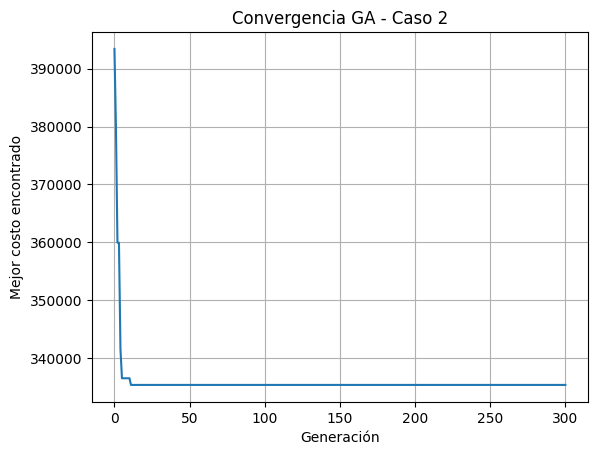


Robustez GA (múltiples semillas):
  Valores: [725776.3042380332, 780528.9396661003, 715574.7489922035, 716327.4890519876, 709596.5373824262]
  Media: 729560.8038661501
  Desviación estándar: 26005.290202181175


In [14]:
# ---------- Convergencia ----------
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history_best2)
plt.xlabel("Generación")
plt.ylabel("Mejor costo encontrado")
plt.title("Convergencia GA - Caso 2")
plt.grid(True)
plt.show()

# ---------- Robustez: varias corridas del GA ----------
seeds = [1, 2, 3, 4, 5]
results_ga_multi = []

for s in seeds:
    best_cost_s, _, _, _ = run_ga(
        instance_base,
        pop_size=80,
        generations=300,
        p_crossover=0.9,
        p_mut=0.2,
        tournament_k=3,
        seed=s
    )
    results_ga_multi.append(best_cost_s)

print("\nRobustez GA (múltiples semillas):")
print("  Valores:", results_ga_multi)
print("  Media:", np.mean(results_ga_multi))
print("  Desviación estándar:", np.std(results_ga_multi))


### Visualizaciones comparativas

#### Mapas comparativos de rutas

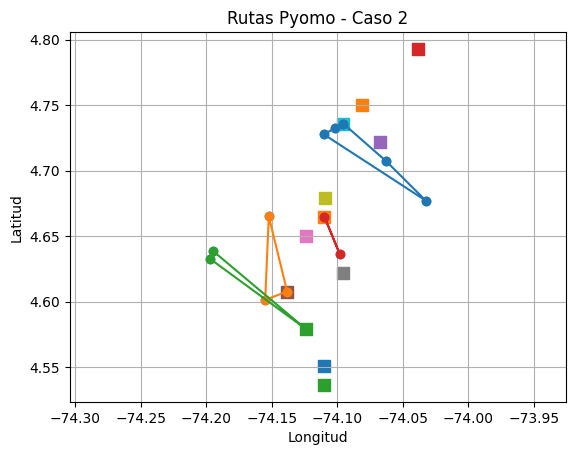

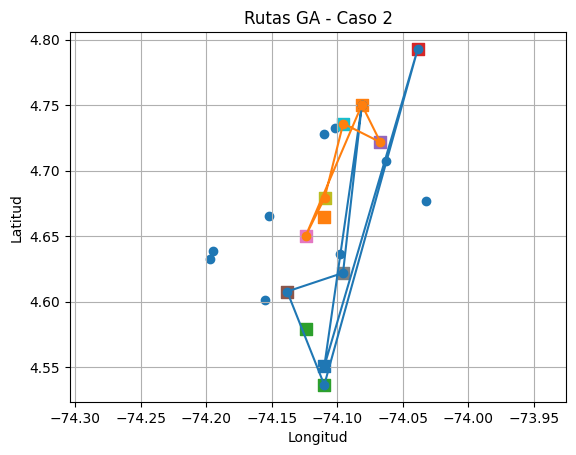

In [16]:
def plot_routes(coords, routes, title):
    plt.figure()
    # plot nodos
    xs = [coords[i][1] for i in coords.keys()]  # longitudes
    ys = [coords[i][0] for i in coords.keys()]  # latitudes
    plt.scatter(xs, ys, marker='o')

    # resaltar centros (H) si quieres
    for h in H:
        plt.scatter(coords[h][1], coords[h][0], s=80, marker='s')

    # dibujar rutas
    for r in routes:
        x_route = [coords[i][1] for i in r]
        y_route = [coords[i][0] for i in r]
        plt.plot(x_route, y_route, marker='o')

    plt.title(title)
    plt.xlabel("Longitud")
    plt.ylabel("Latitud")
    plt.grid(True)
    plt.axis('equal')
    plt.show()

# Rutas Pyomo (lista de listas de nodos internos)
pyomo_routes_list = pyomo_routes_df["route_nodes"].tolist()
# Rutas GA (ya es lista de listas)
ga_routes_list = best_routes2

plot_routes(coords, pyomo_routes_list, "Rutas Pyomo - Caso 2")
plot_routes(coords, ga_routes_list, "Rutas GA - Caso 2")


#### Tiempo vs calidad

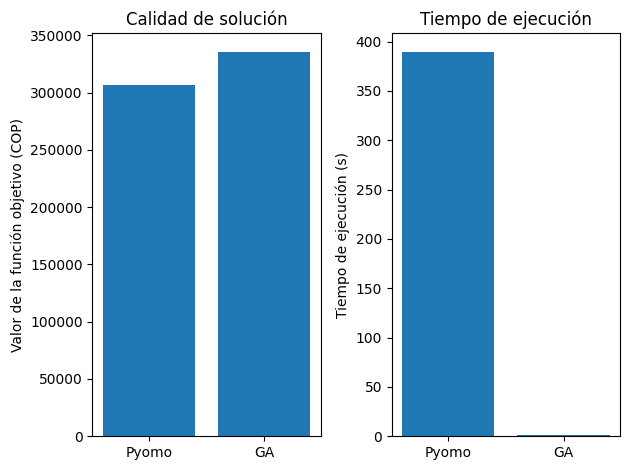

In [17]:
plt.figure()
methods = ["Pyomo", "GA"]
Z_vals  = [Z_py, Z_ga]
times   = [time_pyomo, time_ga]

plt.subplot(1,2,1)
plt.bar(methods, Z_vals)
plt.ylabel("Valor de la función objetivo (COP)")
plt.title("Calidad de solución")

plt.subplot(1,2,2)
plt.bar(methods, times)
plt.ylabel("Tiempo de ejecución (s)")
plt.title("Tiempo de ejecución")

plt.tight_layout()
plt.show()
